# (4) Classification
* team20(안지은, 이정윤)

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format) ## 지수로 출력안하고 소수점 두자리까지 출력

import csv
import numpy as np
from tqdm import tqdm
import pickle

import plotly.express as px ## for visualization
from plotly.subplots import make_subplots
import seaborn as sns ## for visualization
import matplotlib.pyplot as plt ## for visualization

from sklearn.model_selection import train_test_split ## for spliting data
from sklearn.preprocessing import StandardScaler ## for Standardization

from sklearn.preprocessing import MinMaxScaler ## MinMax Normalization
from scipy.stats import boxcox ## for Box-Cox Transformation
from sklearn.decomposition import PCA ## for dimension reduction
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA ## for visualization
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('./data/vehicles_prerocessing_final.csv', index_col = 0)
df_raw.head()

,index_original,year_original,make_original,vin_original,condition_original,odometer_original,mmr_original,sellingprice_original,year,condition,...,mmr,sellingprice,sellingprice_log,odometer_log,mmr_log,index_x,index_y,color,interior,K-Means_cluster
0,0,2015,Kia,5xyktca69fg566472,5.00,16639.00,20500,21500,1.00,1.00,...,0.46,0.47,0.68,0.38,0.67,0,0,white,black,426
1,1,2015,Kia,5xyktca69fg561319,5.00,9393.00,20800,21500,1.00,1.00,...,0.47,0.47,0.68,0.31,0.68,1,1,white,beige,426
2,2,2014,BMW,wba3c1c51ek116351,4.50,1331.00,31900,30000,0.96,0.88,...,0.71,0.66,0.81,0.16,0.84,2,2,gray,black,305
3,3,2015,Volvo,yv1612tb4f1310987,4.10,14282.00,27500,27750,1.00,0.77,...,0.61,0.61,0.77,0.36,0.78,3,3,white,black,272
4,4,2015,Nissan,1n4al3ap1fn326013,1.00,5554.00,15350,10900,1.00,0.00,...,0.34,0.24,0.48,0.26,0.58,4,4,gray,black,347


In [3]:
df_raw.columns

Index(['index_original', 'year_original', 'make_original', 'vin_original',
       'condition_original', 'odometer_original', 'mmr_original',
       'sellingprice_original', 'year', 'condition', 'odometer', 'mmr',
       'sellingprice', 'sellingprice_log', 'odometer_log', 'mmr_log',
       'index_x', 'index_y', 'color', 'interior', 'K-Means_cluster'],
      dtype='object')

In [4]:
### 필요한 컬럼만 남기기
### 클러스터링에 사용한 피쳐 (5개) + 원래 값 (5개) + make
df_clustering = df_raw[['year', 'condition', 'odometer_log', 'mmr_log', 'sellingprice_log', 'year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original', 'make_original']]

In [5]:
df_formodel = df_raw[[ 'year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original']].copy()
df_formodel.rename(columns = {'year_original':'year', 'condition_original': 'condition', 'odometer_original' : 'odometer', 'mmr_original' : 'mmr', 'sellingprice_original' : 'sellingprice'}, inplace = True)
df_formodel.to_csv('./data/df_formodel_final.csv')

In [6]:
df_formodel

,year,condition,odometer,mmr,sellingprice
0,2015,5.00,16639.00,20500,21500
1,2015,5.00,9393.00,20800,21500
2,2014,4.50,1331.00,31900,30000
3,2015,4.10,14282.00,27500,27750
4,2015,1.00,5554.00,15350,10900
...,...,...,...,...,...
434980,2011,3.90,66403.00,20300,22800
434981,2012,5.00,54393.00,30200,30800
434982,2012,4.80,50561.00,29800,34000
434983,2015,3.80,16658.00,15100,11100


### clustering

In [7]:
### clustering model
with open('kmeans_500_model_final.pkl', 'rb') as f:
   clustering_model = pickle.load(f)

In [8]:
### clustering
cluster = clustering_model.predict(df_clustering.loc[:, ['year', 'condition', 'odometer_log', 'mmr_log', 'sellingprice_log']])
df_clustering['cluster'] = cluster

### cluster별 대표값 만들기

In [9]:
result = df_clustering.groupby('cluster').agg({
    'year_original': [lambda x: x.value_counts().index[0]],
    'make_original': [lambda x: x.value_counts().index[0]],
    'condition_original': ['mean', 'median', 'max', 'min'],
    'odometer_original': ['mean', 'median', 'max', 'min'],
    'mmr_original': ['mean', 'median', 'max', 'min'],
    'sellingprice_original': ['mean', 'median', 'max', 'min']
})

# 컬럼명 재설정
result.columns = [
    'count_year',
    'count_make',
    'mean_condition',
    'median_condition',
    'max_condition',
    'min_condition',
    'mean_odometer',
    'median_odometer',
    'max_odometer',
    'min_odometer',
    'mean_mmr',
    'median_mmr',
    'max_mmr',
    'min_mmr',
    'mean_sellingprice',
    'median_sellingprice',
    'max_sellingprice',
    'min_sellingprice'
]

# 결과 출력
result


,count_year,count_make,mean_condition,median_condition,max_condition,min_condition,mean_odometer,median_odometer,max_odometer,min_odometer,mean_mmr,median_mmr,max_mmr,min_mmr,mean_sellingprice,median_sellingprice,max_sellingprice,min_sellingprice
cluster,,,,,,,,,,,,,,,,,,
1,2003,Chevrolet,1.03,1.00,1.40,1.00,4.53,1.00,259.00,1.00,5065.07,5175.00,8675,2250,1089.38,900.00,3700,200
7,2007,Ford,2.70,2.70,2.80,2.60,1.00,1.00,1.00,1.00,8462.50,8275.00,9200,8100,1712.50,2000.00,2400,450
10,2007,Pontiac,2.80,2.80,2.80,2.80,1.00,1.00,1.00,1.00,6100.00,6100.00,6100,6100,8000.00,8000.00,8000,8000
12,2007,Dodge,3.35,3.35,3.50,3.20,1.00,1.00,1.00,1.00,11087.50,11087.50,12450,9725,1050.00,1050.00,1200,900
16,2012,Ford,4.20,4.20,4.20,4.20,1.00,1.00,1.00,1.00,11750.00,11750.00,11750,11750,1700.00,1700.00,1700,1700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,2004,Pontiac,3.70,3.70,3.70,3.70,1.00,1.00,1.00,1.00,2275.00,2275.00,2275,2275,2200.00,2200.00,2200,2200
491,2004,Toyota,3.81,3.80,4.20,3.20,208350.37,208195.00,265817.00,137416.00,4985.62,4850.00,11250,650,7424.34,7100.00,15500,2900
495,2008,Chevrolet,3.56,3.50,3.90,3.20,186804.12,184898.50,267034.00,114518.00,6835.91,6600.00,9875,4025,8317.60,8000.00,15000,4800


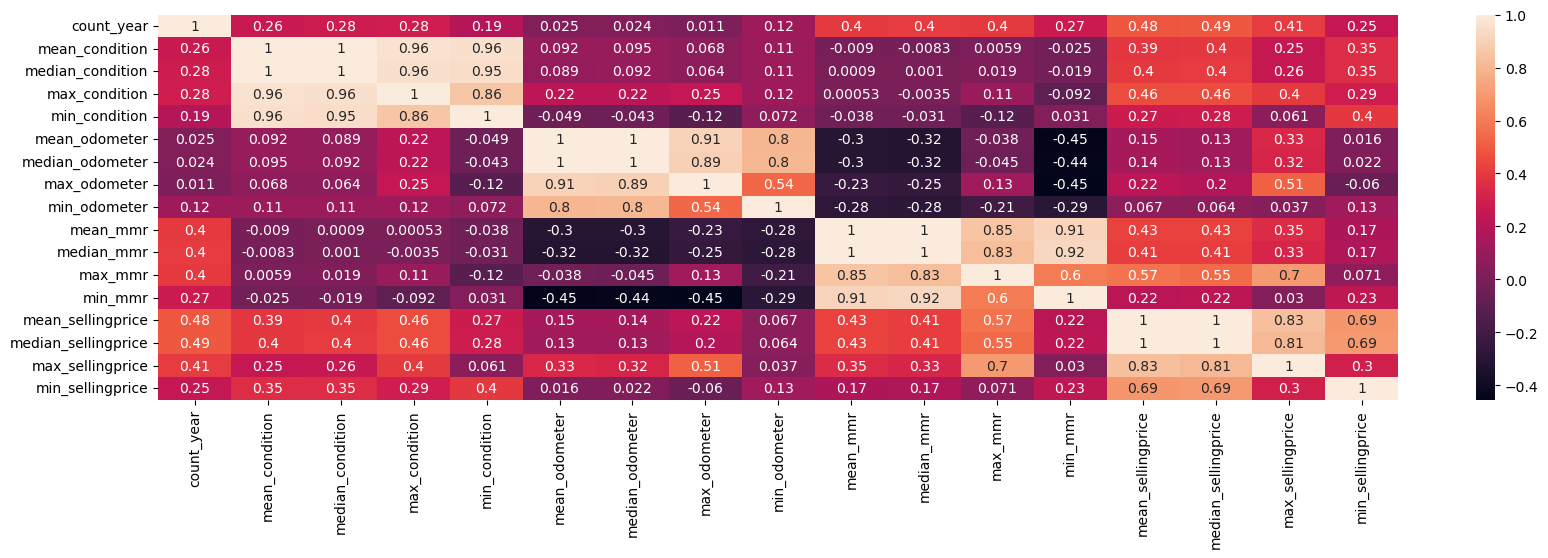

In [10]:
plt.figure(figsize = (20, 5))
sns.heatmap(result.corr(),annot=True)
plt.show()

In [11]:
result = pd.read_excel('./data/model_result_bygroup_final.xlsx')
result

,K-Means_cluster,count_year,count_make,mean_condition,median_condition,max_condition,min_condition,mean_odometer,median_odometer,max_odometer,min_odometer,mean_mmr,median_mmr,max_mmr,min_mmr,mean_sellingprice,median_sellingprice,max_sellingprice,min_sellingprice
0,0,2014,Ford,4.34,4.30,4.50,4.20,32626.40,32488.00,52430,19817,18354.09,18350.00,21500,14400,18608.82,18500,22600,14000
1,1,2006,Chevrolet,1.02,1.00,1.40,1.00,93371.93,95279.50,121681,54725,5070.03,5050.00,10850,1200,2597.80,2400,7000,275
2,2,2010,Chevrolet,3.62,3.60,4.00,3.40,96668.79,96588.00,116064,79289,5657.02,5675.00,8425,2725,5847.27,6000,9000,1500
3,3,2006,Chevrolet,1.97,1.90,2.40,1.50,197723.43,196796.00,222992,180546,2314.36,2100.00,7175,75,2100.36,1950,5800,300
4,4,2011,Nissan,2.78,2.80,3.10,2.40,53530.59,53451.00,70976,26759,12303.73,12250.00,19000,9225,11873.14,11800,15400,7200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,2011,Ford,3.62,3.60,4.00,3.20,70477.22,69606.00,106192,44077,28509.24,28400.00,34900,20500,28560.22,28500,35600,23900
496,496,2011,Mercedes-Benz,2.14,2.10,2.60,1.60,61014.95,58233.00,116793,22273,31304.31,31400.00,37500,22000,29311.25,29000,40600,22700
497,497,2012,Ford,4.85,4.80,5.00,4.60,23569.17,23694.00,42109,2494,16219.91,16150.00,22400,10450,16766.69,16800,21500,10800
498,498,2008,Chevrolet,3.54,3.50,3.90,3.20,63645.33,64436.00,83924,26630,18102.21,18050.00,24600,14250,18475.26,18400,25750,14300


In [12]:
result_formodel = result[['K-Means_cluster', 'count_year', 'count_make', 'mean_condition', 'mean_odometer', 'mean_mmr', 'mean_sellingprice']]
result_formodel.rename(columns={'K-Means_cluster':'cluster'}, inplace=True)
result_formodel.set_index('cluster', inplace=True)
result_formodel.to_json('./data/result_bygroup_final.json', orient='index')
result_formodel.reset_index(inplace=True)

In [13]:
result_formodel

,cluster,count_year,count_make,mean_condition,mean_odometer,mean_mmr,mean_sellingprice
0,0,2014,Ford,4.34,32626.40,18354.09,18608.82
1,1,2006,Chevrolet,1.02,93371.93,5070.03,2597.80
2,2,2010,Chevrolet,3.62,96668.79,5657.02,5847.27
3,3,2006,Chevrolet,1.97,197723.43,2314.36,2100.36
4,4,2011,Nissan,2.78,53530.59,12303.73,11873.14
...,...,...,...,...,...,...,...
495,495,2011,Ford,3.62,70477.22,28509.24,28560.22
496,496,2011,Mercedes-Benz,2.14,61014.95,31304.31,29311.25
497,497,2012,Ford,4.85,23569.17,16219.91,16766.69
498,498,2008,Chevrolet,3.54,63645.33,18102.21,18475.26


### 정규화

1. MinMaxScaler
2. StandardScaler
3. 로그화 + StandardScaler


In [14]:
# 클러스터별 대표값 결과값 
df_result_scaling = result_formodel.copy()

case = ['minmax_scaler', 'standard_scaler', 'log+standard_scaler']

standard_scaler = StandardScaler() # StandardScaler
minmax_scaler = MinMaxScaler() # MinMaxScaler 


for i in tqdm(range(len(case))):
    
    if case[i] == "minmax_scaler":
        ## minmax_scaler
        minmax_scaler.fit(df_result_scaling.drop(['cluster', 'count_make'], axis=1)) # 정규화를 수행 함수 생성
        transformed_2 = minmax_scaler.transform(df_result_scaling.drop(['cluster', 'count_make'], axis=1)) 
        
        df_result_std_tmp= pd.DataFrame(transformed_2)
        df_result_std_tmp.columns = df_result_scaling.drop(['cluster', 'count_make'], axis=1).columns
        df_result_std_tmp['cluster'] = df_result_scaling['cluster']
    
    elif case[i] == "standard_scaler":
        ## standard_scaler
        standard_scaler.fit(df_result_scaling.drop(['cluster', 'count_make'], axis=1)) # 표준화를 수행 함수 생성
        transformed_1 = standard_scaler.transform(df_result_scaling.drop(['cluster', 'count_make'], axis=1)) # 표준화 수행
        
        df_result_minmax_tmp= pd.DataFrame(transformed_1)
        df_result_minmax_tmp.columns = df_result_scaling.drop(['cluster', 'count_make'], axis=1).columns
        df_result_minmax_tmp['cluster'] = df_result_scaling['cluster']
        
    elif case[i] == 'log+standard_scaler':
        ## 로그화
        df_result_scaling['sellingprice_log'], _ = boxcox(df_result_scaling['mean_sellingprice'])
        df_result_scaling['odometer_log'], _ = boxcox(df_result_scaling['mean_odometer'])
        df_result_scaling['mmr_log'], _ = boxcox(df_result_scaling['mean_mmr'])
        
        ## standard_scaler
        standard_scaler.fit(df_result_scaling.drop(['cluster', 'mean_odometer', 'mean_mmr', 'mean_sellingprice', 'count_make'], axis=1)) # 표준화를 수행 함수 생성
        transformed_3 = standard_scaler.transform(df_result_scaling.drop(['cluster', 'mean_odometer', 'mean_mmr', 'mean_sellingprice', 'count_make'], axis=1)) # 표준화 수행
        
        df_result_logstd_tmp= pd.DataFrame(transformed_3)
        df_result_logstd_tmp.columns = df_result_scaling.drop(['cluster', 'mean_odometer', 'mean_mmr', 'mean_sellingprice', 'count_make'], axis=1).columns
        df_result_logstd_tmp['cluster'] = df_result_scaling['cluster']
        
    else:
        print("error")
        

100%|██████████| 3/3 [00:00<00:00, 134.02it/s]


In [15]:
df_result_minmax_tmp

,count_year,mean_condition,mean_odometer,mean_mmr,mean_sellingprice,cluster
0,1.16,1.10,-0.86,0.55,0.61,0
1,-0.75,-2.25,0.24,-0.88,-1.11,1
2,0.21,0.37,0.30,-0.81,-0.77,2
3,-0.75,-1.29,2.13,-1.18,-1.17,3
4,0.45,-0.47,-0.48,-0.10,-0.12,4
...,...,...,...,...,...,...
495,0.45,0.38,-0.17,1.65,1.67,495
496,0.45,-1.12,-0.34,1.95,1.75,496
497,0.69,1.62,-1.02,0.32,0.41,497
498,-0.27,0.29,-0.29,0.53,0.59,498


In [16]:
df_result_std_tmp

,count_year,mean_condition,mean_odometer,mean_mmr,mean_sellingprice,cluster
0,1.00,0.85,0.13,0.42,0.43,0
1,0.58,0.01,0.38,0.10,0.05,1
2,0.79,0.67,0.39,0.12,0.12,2
3,0.58,0.25,0.80,0.04,0.04,3
4,0.84,0.45,0.21,0.28,0.27,4
...,...,...,...,...,...,...
495,0.84,0.67,0.28,0.66,0.66,495
496,0.84,0.29,0.24,0.73,0.68,496
497,0.89,0.98,0.09,0.37,0.38,497
498,0.68,0.65,0.25,0.41,0.42,498


In [17]:
df_result_logstd_tmp

,count_year,mean_condition,sellingprice_log,odometer_log,mmr_log,cluster
0,1.16,1.10,0.75,-0.83,0.71,0
1,-0.75,-2.25,-1.37,0.46,-0.86,1
2,0.21,0.37,-0.67,0.52,-0.76,2
3,-0.75,-1.29,-1.51,1.70,-1.53,3
4,0.45,-0.47,0.12,-0.28,0.14,4
...,...,...,...,...,...,...
495,0.45,0.38,1.45,0.07,1.44,495
496,0.45,-1.12,1.50,-0.11,1.61,496
497,0.69,1.62,0.59,-1.16,0.53,497
498,-0.27,0.29,0.74,-0.06,0.69,498


In [18]:
# 전체값 
df_total_scaling = df_clustering.copy()

# case = ['minmax_scaler', 'standard_scaler', 'log+standard_scaler']

# standard_scaler = StandardScaler() # StandardScaler
# minmax_scaler = MinMaxScaler() # MinMaxScaler 

for i in tqdm(range(len(case))):
    if case[i] == "standard_scaler":
        ## standard_scaler
        standard_scaler.fit(df_total_scaling[['year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original', "cluster"]]) # 표준화를 수행 함수 생성
        transformed_1 = standard_scaler.transform(df_total_scaling[['year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original', "cluster"]]) # 표준화 수행
        
        df_total_minmax_tmp= pd.DataFrame(transformed_1)
        df_total_minmax_tmp.columns = df_total_scaling[['year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original', "cluster"]].columns
        df_total_minmax_tmp['cluster'] = df_total_scaling['cluster']
        
    elif case[i] == "minmax_scaler":
        ## minmax_scaler
        minmax_scaler.fit(df_total_scaling[['year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original', "cluster"]]) # 정규화를 수행 함수 생성
        transformed_2 = minmax_scaler.transform(df_total_scaling[['year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original', "cluster"]]) 
        
        df_total_std_tmp= pd.DataFrame(transformed_2)
        df_total_std_tmp.columns = df_total_scaling[['year_original', 'condition_original', 'odometer_original', 'mmr_original', 'sellingprice_original', "cluster"]].columns
        df_total_std_tmp['cluster'] = df_total_scaling['cluster']
        
    elif case[i] == 'log+standard_scaler':
        ## 로그화 이미 해줌
        ## standard_scaler
        standard_scaler.fit(df_total_scaling[['year_original', 'condition_original', "odometer_log", "mmr_log", "sellingprice_log", 'cluster']]) # 표준화를 수행 함수 생성
        transformed_3 = standard_scaler.transform(df_total_scaling[['year_original', 'condition_original', "odometer_log", "mmr_log", "sellingprice_log", 'cluster']]) # 표준화 수행
        
        df_total_logstd_tmp= pd.DataFrame(transformed_3)
        df_total_logstd_tmp.columns = df_total_scaling[['year_original', 'condition_original', "odometer_log", "mmr_log", "sellingprice_log", 'cluster']].columns
        df_total_logstd_tmp['cluster'] = df_total_scaling['cluster']
        
    else:
        print("error")
        

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 14.46it/s]


In [19]:
df_total_minmax_tmp

,year_original,condition_original,odometer_original,mmr_original,sellingprice_original,cluster
0,1.28,1.70,-1.02,0.88,1.01,407
1,1.28,1.70,-1.17,0.92,1.01,407
2,1.01,1.17,-1.33,2.27,2.03,407
3,1.28,0.74,-1.07,1.73,1.76,407
4,1.28,-2.56,-1.25,0.26,-0.26,89
...,...,...,...,...,...,...
434980,0.23,0.53,-0.02,0.86,1.17,407
434981,0.49,1.70,-0.26,2.06,2.13,407
434982,0.49,1.49,-0.34,2.01,2.51,407
434983,1.28,0.42,-1.02,0.23,-0.24,407


In [20]:
df_total_logstd_tmp

,year_original,condition_original,odometer_log,mmr_log,sellingprice_log,cluster
0,1.28,1.70,-1.22,0.92,1.02,407
1,1.28,1.70,-1.65,0.95,1.02,407
2,1.01,1.17,-2.63,1.88,1.72,407
3,1.28,0.74,-1.34,1.53,1.55,407
4,1.28,-2.56,-1.98,0.40,-0.10,89
...,...,...,...,...,...,...
434980,0.23,0.53,0.23,0.91,1.13,407
434981,0.49,1.70,-0.02,1.75,1.79,407
434982,0.49,1.49,-0.11,1.72,2.02,407
434983,1.28,0.42,-1.22,0.38,-0.07,407


In [21]:
df_total_logstd_tmp

,year_original,condition_original,odometer_log,mmr_log,sellingprice_log,cluster
0,1.28,1.70,-1.22,0.92,1.02,407
1,1.28,1.70,-1.65,0.95,1.02,407
2,1.01,1.17,-2.63,1.88,1.72,407
3,1.28,0.74,-1.34,1.53,1.55,407
4,1.28,-2.56,-1.98,0.40,-0.10,89
...,...,...,...,...,...,...
434980,0.23,0.53,0.23,0.91,1.13,407
434981,0.49,1.70,-0.02,1.75,1.79,407
434982,0.49,1.49,-0.11,1.72,2.02,407
434983,1.28,0.42,-1.22,0.38,-0.07,407


### PCA

In [22]:
def pca(df):
    pca = PCA(n_components=1)
    principalComponents = pca.fit_transform(df.drop(['cluster'], axis=1))
    principalDf = pd.DataFrame(data=principalComponents, columns = ['pc1'])
    principalDf['cluster'] = df['cluster']
    return principalDf

In [23]:
## 클러스터별 대표값 pca

pca(df_result_minmax_tmp)
pca(df_result_std_tmp)
pca(df_result_logstd_tmp)

,pc1,cluster
0,-1.99,0
1,2.42,1
2,0.70,2
3,3.01,3
4,-0.29,4
...,...,...
495,-1.74,495
496,-1.41,496
497,-1.91,497
498,-0.70,498


In [24]:
### 전체 데이터 PCA
pca(df_total_minmax_tmp)
pca(df_total_std_tmp)
pca(df_total_logstd_tmp)

,pc1,cluster
0,-2.69,407
1,-2.89,407
2,-3.78,407
3,-2.92,407
4,-0.62,89
...,...,...
434980,-1.18,407
434981,-2.57,407
434982,-2.63,407
434983,-1.41,407


### 가장 유사한 class cluster 값 부여

In [25]:
df_result_minmax_knn = pca(df_result_minmax_tmp)

x_train = np.array(df_result_minmax_knn['pc1']).reshape(-1, 1)
y_train = np.array(df_result_minmax_knn['cluster']).reshape(-1, 1)

knn_result = []
knn_accuracy = []
knn_f1 = []

for k in range(1, 15):
    knn = KNeighborsClassifier(n_jobs=-1, n_neighbors = k)
    knn.fit(x_train, y_train)
    knn_result.append(knn.predict(x_train))
    knn_accuracy.append(knn.score(x_train, y_train))
    knn_f1.append(f1_score(y_train, knn.predict(x_train), average='macro'))
    
    print("k: ", k, "accuracy: ", knn.score(x_train, y_train), "f1-score: ", f1_score(y_train, knn.predict(x_train), average='macro'))

k:  1 accuracy:  1.0 f1-score:  1.0
k:  2 accuracy:  0.53 f1-score:  0.4023333333333334
k:  3 accuracy:  0.338 f1-score:  0.2019333333333333
k:  4 accuracy:  0.248 f1-score:  0.11488571428571429
k:  5 accuracy:  0.192 f1-score:  0.07636190476190477
k:  6 accuracy:  0.17 f1-score:  0.06240793650793651
k:  7 accuracy:  0.144 f1-score:  0.04542727272727273
k:  8 accuracy:  0.126 f1-score:  0.037607070707070714
k:  9 accuracy:  0.114 f1-score:  0.032197635697635694
k:  10 accuracy:  0.096 f1-score:  0.022745143745143748
k:  11 accuracy:  0.09 f1-score:  0.0200007992007992
k:  12 accuracy:  0.084 f1-score:  0.01688733651968946
k:  13 accuracy:  0.078 f1-score:  0.016705385137738078
k:  14 accuracy:  0.072 f1-score:  0.015096478839358099


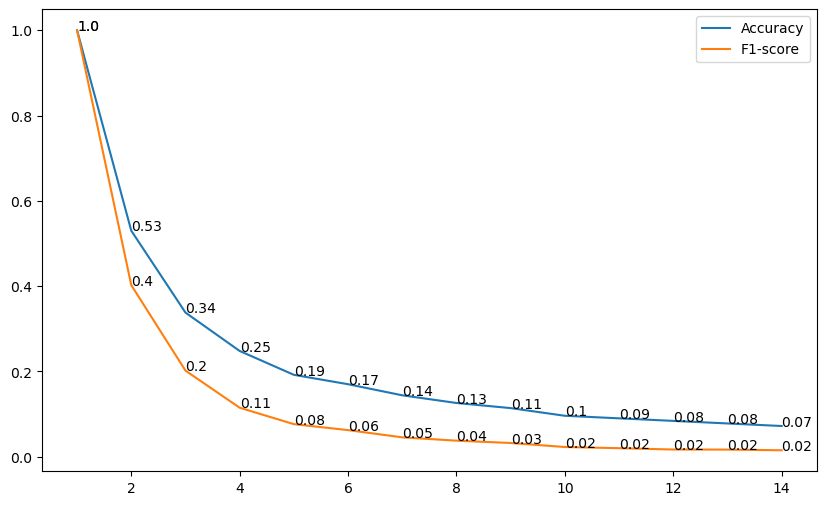

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), knn_accuracy, label='Accuracy')
plt.plot(range(1, 15), knn_f1, label='F1-score')
## 그래프 위에 숫자 표시
for i in range(1, 15):
    plt.text(i, knn_accuracy[i-1], round(knn_accuracy[i-1], 2))
    plt.text(i, knn_f1[i-1], round(knn_f1[i-1], 2))
## legend 표시
plt.legend()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_train, knn_result[1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         1
           2       0.50      1.00      0.67         1
           3       0.50      1.00      0.67         1
           4       0.50      1.00      0.67         1
           5       0.33      1.00      0.50         1
           6       0.50      1.00      0.67         1
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         1
           9       0.50      1.00      0.67         1
          10       0.33      1.00      0.50         1
          11       0.50      1.00      0.67         1
          12       0.50      1.00      0.67         1
          13       0.33      1.00      0.50         1
          14       0.50      1.00      0.67         1
          15       0.50      1.00      0.67         1
          16       1.00      1.00      1.00         1
          17       0.50    

In [29]:
# k = 2 일때 모델 학습
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors = 1)
knn.fit(x_train, y_train)

knn_label = knn.predict(np.array(pca(df_total_minmax_tmp)['pc1']).reshape(-1, 1))

In [30]:
df_knn = pd.DataFrame({'label':knn_label, 'pca': pca(df_total_minmax_tmp)['pc1'], 'cluster': pca(df_total_minmax_tmp)['cluster']})
df_knn

,label,pca,cluster
0,452,-2.58,407
1,84,-2.66,407
2,367,-3.54,407
3,272,-3.00,407
4,245,-0.14,89
...,...,...,...
434980,203,-1.28,407
434981,272,-2.98,407
434982,86,-3.10,407
434983,476,-1.18,407


In [31]:
## 최종 knn 모델
x_train_final = np.array(df_knn['pca']).reshape(-1, 1)
y_train_final = np.array(df_knn['label']).reshape(-1, 1)

knn = KNeighborsClassifier(n_jobs=-1, n_neighbors = 2)
knn.fit(x_train_final, y_train_final)

KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

In [32]:
# 모델 저장
with open('./model/knn_2_model_final.pkl', 'wb') as f:
    pickle.dump(knn, f)